# Strik & Kod
author: "Max Odsbjerg Pedersen & Mathias Johansson"
date: "2024-10-07"

This document consists of the coding part of the workshop "Strik og Kod" (Knit and Code) from AU Library at the Royal Danish Library. The workshop is about drawing parallels between knitting and coding. "Coding" is understood here as the connection between coding-based data processing and is therefore within the field of data science. As the workshop is made in the context of the Arts the example will regard text mining. When text mining the primary interest is pulling information out of large corpuses - which is the exact interest of many humanists.

No recipe is complete without a picture of the final product as one of the first items. And this is no exception. The final result at the end of this document is the visualisation shown just under this paragraph. It shows the most frequently appearing words in old newspaper articles concerning knitting after all stopwords has been removed (it, that, to, and, in - words which bear no larger meaning).

![](https://raw.githubusercontent.com/maxodsbjerg/strik-og-kod/refs/heads/main/notebooks/graphics/strikke_wordcloud.png)

Knitting words and words which accompany them.

<br>



## Downloading and installing Python packages

We work in the programming language Python, it affords a lot of possibilities for working with statistic and graphical presentation of the results. Python works with libraries, these libraries add different functionalities to the Python functionalities.

In this workshop the relevant packages are:


In [15]:
print("install and load libraries")
!python -m pip install pandas wordcloud matplotlib

import re
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

install and load libraries

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Data – articles about knitting

The first thing we need is some text data. We will here use data from the Danish newspaper collection. The data is supplied by the Royal Danish Library experimental Newspaper-API. Interaction with the API builds on searches on Mediestream which is the Royal Danish Libraries platform searching in the newspaper collection and other. Before using the API it is a good idea to get acquainted with the expanded searching codes of Mediestream. To learn the search tips of Mediestream - <https://www2.statsbiblioteket.dk/mediestream/info/soegetips>

You can also see the actual search code which is used here:
<https://gist.github.com/maxodsbjerg/e2dd484d3c9dcaa9c422a861d6a93f6e>

When you feel confident with limiting your searches with search codes you can use this interface to make calls to the Newspaper API:
<http://labs.statsbiblioteket.dk/labsapi/api//api-docs?url=/labsapi/api/openapi.yaml> (Choose "aviser(newspapers)/export/fields")

We have in this workshop prepared an API-call that makes the following search which will returns the matches as data:

> strik\* AND py:[1845 TO 1850] NOT familyId:(stcroixavisdvi OR sanctthomaetidendedvi)

This search gives us articles from the collection in the period 1845 to 1850, that contains words which begins with “strik” (knit) and have all possible endings. And so, we matches such as: “strikke” (knit), “strikning” (knitting), “striktøj”(knit cloth) and “strikketøj” (knitwear). But we also get other words such as “strikt” (strict).

Searches in Mediestream looks like this: ![](https://raw.githubusercontent.com/maxodsbjerg/strik-og-kod/refs/heads/main/pics/mediestream_strik.png) 

But the data that the API returns to us is available as files in CSV-format (Comma Separated Values). To gain access to the data the API returns a link. This link contains the file which is our data. For some the link will open the file in your browser and you will then be able to see something like this: 

![](https://raw.githubusercontent.com/maxodsbjerg/strik-og-kod/refs/heads/main/pics/api_strik.png) 

For others the link will download the csv-file to your computer. The most important thing that the API returns is a link to the raw data which matches our search. Without any unnecessary colouring or available interface that we can interact with as in the Mediestream-search above. The raw data can be loaded directly into R and we will afterwards be able to handle the data. Let us get our articles on knitting into R!

### Load data

First we use the URL we have gotten from the API to download the corpus-csv file to disk.

In [2]:
!wget -c -nc "http://labs.statsbiblioteket.dk/labsapi/api/aviser/export/fields?query=strik%2A%20AND%20py%3A%5B1845%20TO%201850%5D%20NOT%20familyId%3A%28stcroixavisdvi%20OR%20sanctthomaetidendedvi%29&fields=link&fields=timestamp&fields=fulltext_org&fields=familyId&fields=lplace&max=-1&structure=header&structure=content&format=CSV" -O corpus.csv

File ‘corpus.csv’ already there; not retrieving.


Then we use the function `read_csv` from the pandas library to load the file's contents into a DataFrame and keep that in memory under the variable name "strik".
A DataFrame is comparable to spreadsheet in that it is a large matrix that stores data we work with.


In [3]:
strik = pd.read_csv("corpus.csv")

This gives us a new Pandas DataFrame named “strik” and containing 7810 rows and 16 columns.

What is especially interesting for us is the column “fulltext_org” – This is
where the text from the articles is stored. At first the text will not be easy
on the eyes as it is filled with errors, and it is here where you meet the
first downside of working with old text: OCR-errors.

To understand why these errors occur it is necessary to turn towards the
digitalization. In this process the newspapers are photocopied (either from
microfilm or from the original), afterwards a computer algorithm runs through
the pages of the newspapers. The computer algorithm does two things:

  1. Segmenting the articles – with other words the algorithm guesses which
  body belongs to which headline.
  2. Doing text recognition so that the text becomes digital and becomes
  searchable. This is also called OCR (Optical Character Recognition).

This algorithm has been developed with modern newspapers in mind and is
therefore pretty precise when used on more recent newspapers (from 1910
until today). If the algorithm is used on older material the quality of
the digitalization dwindles. This is in part due to layout of older newspapers
differ from modern layouts. One of the big problems are that the text
recognition is bad. This is a result of the typeface used in old newspapers
which used fraktur when pressing newspapers. Some will recognize the typeface
as gothic letters or curly letters. ![](https://raw.githubusercontent.com/maxodsbjerg/strik-og-kod/refs/heads/main/pics/fraktur.png) Our hope here is
that the data is so large that we can gather something interesting despite
the OCR-errors.



## The Text mining task


First we will convert the text into lowercase and split it into words using [Regular expression](https://en.wikipedia.org/wiki/Regex).
We store these `lists` of lowercase words in the DataFrame in the column `word` and we expand this column into a new dataframe where each word has its own row.


In [4]:
strik['word'] = strik.fulltext_org.apply(lambda x: re.findall(r'\w+', x.lower()))
strik_tidy = strik.explode('word')

Let us just print out the new data frame to see how the tidytext format looks in practice. This is achieved by writing the name of the data frame:

In [5]:
strik_tidy

,link,timestamp,fulltext_org,familyId,lplace,word
0,http://www2.statsbiblioteket.dk/mediestream/av...,1845-01-01T01:00:00,17. Formanden fremlagte en fra Nyborg Amtstue ...,fyensstiftstidende,Odense,17
0,http://www2.statsbiblioteket.dk/mediestream/av...,1845-01-01T01:00:00,17. Formanden fremlagte en fra Nyborg Amtstue ...,fyensstiftstidende,Odense,formanden
0,http://www2.statsbiblioteket.dk/mediestream/av...,1845-01-01T01:00:00,17. Formanden fremlagte en fra Nyborg Amtstue ...,fyensstiftstidende,Odense,fremlagte
0,http://www2.statsbiblioteket.dk/mediestream/av...,1845-01-01T01:00:00,17. Formanden fremlagte en fra Nyborg Amtstue ...,fyensstiftstidende,Odense,en
0,http://www2.statsbiblioteket.dk/mediestream/av...,1845-01-01T01:00:00,17. Formanden fremlagte en fra Nyborg Amtstue ...,fyensstiftstidende,Odense,fra
...,...,...,...,...,...,...
4378,http://www2.statsbiblioteket.dk/mediestream/av...,1850-12-31T01:00:00,Th eatret i O d en fe«\nE)nsdag : Skuespilleri...,fyensstiftstidende,Odense,ved
4378,http://www2.statsbiblioteket.dk/mediestream/av...,1850-12-31T01:00:00,Th eatret i O d en fe«\nE)nsdag : Skuespilleri...,fyensstiftstidende,Odense,p
4378,http://www2.statsbiblioteket.dk/mediestream/av...,1850-12-31T01:00:00,Th eatret i O d en fe«\nE)nsdag : Skuespilleri...,fyensstiftstidende,Odense,thuesen
4378,http://www2.statsbiblioteket.dk/mediestream/av...,1850-12-31T01:00:00,Th eatret i O d en fe«\nE)nsdag : Skuespilleri...,fyensstiftstidende,Odense,i


If we flip through the columns (with the little black arrow in the top-right corner) the last column will now be “word” which only contains single words.

## Analysis

### Wordcloud

To get an overview of our dataset we will begin by counting the most used words in the article about knitting in the period 1845 to 1850:


In [6]:
Counter(strik_tidy.word.values).most_common()

[('i', 76925),
 ('og', 65355),
 ('en', 52559),
 ('til', 38981),
 ('at', 37116),
 ('af', 30864),
 ('den', 27438),
 ('paa', 23571),
 ('som', 23090),
 ('er', 21855),
 ('med', 21526),
 ('for', 20804),
 ('et', 18950),
 ('de', 18612),
 ('det', 17395),
 ('fra', 15605),
 ('der', 14021),
 ('sig', 13281),
 ('ved', 11638),
 ('2', 10677),
 ('kan', 10111),
 ('a', 9758),
 ('ikke', 9476),
 ('har', 9084),
 ('eller', 8810),
 ('s', 8663),
 ('han', 8619),
 ('om', 8158),
 ('m', 7954),
 ('l', 7831),
 ('hun', 7799),
 ('t', 7736),
 ('sal', 7696),
 ('1', 6975),
 ('n', 6943),
 ('d', 6845),
 ('man', 6751),
 ('pige', 6500),
 ('3', 6423),
 ('e', 6338),
 ('r', 6164),
 ('var', 5957),
 ('nr', 5872),
 ('mk', 5679),
 ('men', 5431),
 ('iste', 5342),
 ('da', 5219),
 ('jeg', 5218),
 ('al', 5149),
 ('hos', 5128),
 ('rbd', 5126),
 ('g', 4914),
 ('h', 4905),
 ('hvor', 4893),
 ('have', 4874),
 ('4', 4664),
 ('c', 4638),
 ('saa', 4477),
 ('denne', 4449),
 ('f', 4360),
 ('par', 4208),
 ('over', 4147),
 ('as', 4136),
 ('ere', 4

<br> To no one’s surprise most frequent words in the dataset is the grammatical particles. One way to negate these words is by using a stopword list which can be used to remove unwanted words:

In [7]:
!wget "https://gist.githubusercontent.com/maxodsbjerg/4d1e3b1081ebba53a8d2c3aae2a1a070/raw/e1f63b4c81c15bb58a54a2f94673c97d75fe6a74/stopord_18.csv" -O stopord.csv


--2024-10-07 22:18:38--  https://gist.githubusercontent.com/maxodsbjerg/4d1e3b1081ebba53a8d2c3aae2a1a070/raw/e1f63b4c81c15bb58a54a2f94673c97d75fe6a74/stopord_18.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1312 (1.3K) [text/plain]
Saving to: ‘stopord.csv’

stopord.csv         100%[===================>]   1.28K  --.-KB/s    in 0s      

2024-10-07 22:18:38 (40.5 MB/s) - ‘stopord.csv’ saved [1312/1312]



In [8]:
stopord = pd.read_csv("stopord.csv")['word'].to_list()

<br>


We will filter out all the stopwords !!

In [13]:
def not_stopword(word):
  return word not in stopord

words = Counter(filter(not_stopword, strik_tidy.word.values)).most_common()
words

[('sal', 7696),
 ('pige', 6500),
 ('iste', 5342),
 ('hos', 5128),
 ('rbd', 5126),
 ('par', 4208),
 ('lille', 3839),
 ('faae', 3310),
 ('stuen', 3235),
 ('anvises', 2983),
 ('lste', 2922),
 ('onster', 2830),
 ('ung', 2797),
 ('2den', 2770),
 ('godt', 2723),
 ('mig', 2679),
 ('gode', 2633),
 ('eondition', 2369),
 ('dito', 2332),
 ('condition', 2240),
 ('strar', 2151),
 ('henvende', 1842),
 ('karl', 1838),
 ('selv', 1756),
 ('enepige', 1719),
 ('gaae', 1717),
 ('bliver', 1619),
 ('tro', 1607),
 ('3die', 1583),
 ('anden', 1571),
 ('behage', 1547),
 ('kondition', 1528),
 ('sort', 1450),
 ('familie', 1446),
 ('os', 1422),
 ('cn', 1378),
 ('rr', 1365),
 ('stal', 1351),
 ('deel', 1305),
 ('bedes', 1300),
 ('tjener', 1283),
 ('tabt', 1281),
 ('anbefalinger', 1234),
 ('w', 1234),
 ('ho', 1228),
 ('nye', 1225),
 ('sine', 1212),
 ('onffer', 1199),
 ('hver', 1198),
 ('billet', 1195),
 ('douceur', 1176),
 ('sit', 1176),
 ('hvori', 1150),
 ('maatte', 1149),
 ('hvis', 1140),
 ('kongensgade', 1135),
 (

<br> We can already see quite a few interesting words. Something points
towards a connection between maids that are seeking “condition” which back
in the day meant a “service position” or a space of sorts. We can also see
an OCR-error “eondition” and another spelling of condition, “kondition”.

But a list is a little boring to look at. Could we perhaps create a
beautiful wordcloud? Of course we can!


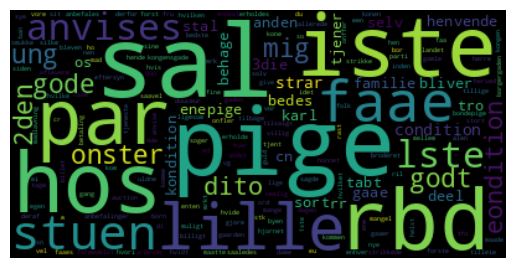

In [21]:
wc = WordCloud()
wc.generate_from_frequencies(
  Counter(filter(not_stopword, strik_tidy.word.values))).to_file('wc.png')
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()